In [3]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from matplotlib.lines import Line2D

def QSE(t_max, T_kelvin, gamma_0, n, c,time_step):
    """
    This function simulates the quantum engine cycle and returns the efficiency
    and other thermodynamic quantities.
    """
    # Natural Units Scaling
    hbar_si = 1.0545718e-34
    m_si = 9.10938356e-31
    k_si = 1.38064852e-23
    L_si = 10 * 10**(-9)
    L0 = 10**(-9)
    E0 = hbar_si**2 / (2 * m_si * L_si**2)
    t_0 = hbar_si / E0
    hbar = 1
    m = 1
    T = T_kelvin * k_si / E0
    L = L_si / L0
    k = 1
    beta = 1 / (k * T)
    x_vals = np.linspace(0, L, n)
    dx = x_vals[1] - x_vals[0]

    # Kinetic Hamiltonian
    H_kinetic = -hbar**2 / (2 * m * dx**2) * (-2 * np.eye(n) + np.eye(n, k=1) + np.eye(n, k=-1))
    H_kinetic = Qobj(H_kinetic)

    # Barrier functions
    def DDF_exp(x, dx_offset):
        barrier_height = 2.0
        barrier_width = 0.15 * L
        barrier_center = L / 2 + dx_offset
        x_start = barrier_center - barrier_width / 2
        x_end = barrier_center + barrier_width / 2
        potential = np.where((x >= x_start) & (x <= x_end), barrier_height, 0.0)
        return potential

    def DDF(x):
        barrier_height = 2.0
        barrier_width = 0.15 * L
        barrier_center = L / 2
        x_start = barrier_center - barrier_width / 2
        x_end = barrier_center + barrier_width / 2
        potential = np.where((x >= x_start) & (x <= x_end), barrier_height, 0.0)
        return potential

    # Time-dependent Hamiltonian
    alpha_func = lambda t: c * t
    def H_t(x, t, alpha_func):
        delta_matrix = Qobj(DDF(x) * np.eye(n))
        return H_kinetic + alpha_func(t) * delta_matrix

    # Collapse operators and thermal state
    def N_wk(omega):
        epsilon = np.finfo(float).eps
        exponent = np.clip(beta * hbar * omega, None, 700)
        return 1 / (np.exp(exponent) - 1 + epsilon)

    def collapse_ops(H):
        eigenvals, eigenstates = H.eigenstates()
        c_ops_list = []
        omega_k = np.diff(eigenvals) / hbar
        gamma_k = [gamma_0 * omega for omega in omega_k]
        for k_idx in range(1, n):
            L_k = eigenstates[k_idx - 1] * eigenstates[k_idx].dag()
            N_k = N_wk(omega_k[k_idx - 1])
            gamma_term1 = float(gamma_k[k_idx - 1] * (N_k + 1))
            gamma_term2 = float(gamma_k[k_idx - 1] * N_k)
            c_ops_list.append(L_k * np.sqrt(gamma_term1))
            c_ops_list.append(L_k.dag() * np.sqrt(gamma_term2))
        return c_ops_list

    def thermal(H):
        rho_n = (-beta * H).expm()
        return rho_n / rho_n.tr()
        
    def get_coherence_measures(rho_list, H_list):
        rho_e_basis = []
        for i in range(len(rho_list)):
            H_now = H_list[i]
            rho_now = rho_list[i]
            _ , evecs = H_now.eigenstates()
            U = Qobj(np.column_stack([e.full() for e in evecs]))
            rho_e_basis.append(U.dag() * rho_now * U)

        l1_list = [
            np.sum(np.abs(r.full() - np.diag(np.diag(r.full())))) for r in rho_e_basis
        ]
        diagonal_states = [Qobj(np.diag(r.diag()), dims=r.dims) for r in rho_e_basis]
        rel_entropy_list = [
            entropy_vn(d_r) - entropy_vn(r) for d_r, r in zip(diagonal_states, rho_e_basis)
        ]
        C_w_list = []
        for rho_t in rho_e_basis:
            rho_array = rho_t.full()
            diagonal = np.diagonal(rho_array)
            off_diagonal = np.abs(rho_array - np.diag(diagonal))
            numerator = np.sum(diagonal * np.sum(off_diagonal, axis=1))
            denominator = np.sum(diagonal)
            C_w = numerator #/ denominator if denominator != 0 else 0
            C_w_list.append(C_w)
        
        return {
            'l1': l1_list,
            'rel_entropy': rel_entropy_list,
            'C_w': C_w_list
        }


    # --- INSERTION PROCESS ---
    #t_max = 5
    
    times = np.linspace(0, t_max, time_step)
    options = {'method': 'bdf', 'nsteps': 500000, 'atol': 1e-12, 'rtol': 1e-10}
    
    H0 = H_t(x_vals, 0, alpha_func)
    ground_energy, ground_ket = H0.groundstate()
    rho0 = ground_ket * ground_ket.dag()
    #rho0 = thermal(H0)
    
    rho_list = []
    rho_q_list = []
    H_ins_list = []
    fid_ins = []
    pop_ins = []
    e_levels = []
    pop_qins = []
    for t_idx in range(len(times) - 1):
        H_now = H_t(x_vals, times[t_idx], alpha_func)
        H_ins_list.append(H_now)
        
        evals, evecs = H_now.eigenstates()
        U = Qobj(np.column_stack([e.full() for e in evecs]))
        rho_e = U.dag() * rho0 * U
        pop_ins.append(np.real(rho_e.diag()))
        e_levels.append(np.array(evals))
        rho_thermal_now = thermal(H_now)
        rho_q_list.append(rho_thermal_now)

        exp_vals = np.exp(-beta * evals)
        Z = np.sum(exp_vals)
        rho_e_q = exp_vals / Z
        pop_qins.append(rho_e_q)
        
        fid_ins.append(fidelity(rho_thermal_now, rho0))
        c_ops = collapse_ops(H_now)
        t_span = [times[t_idx], times[t_idx + 1]]
        result = mesolve(H_now, rho0, t_span, c_ops, options=options)
        rho_list.append(rho0)
        rho0 = result.states[-1]
    rho_list.append(rho0)
    H_final_ins = H_t(x_vals, times[-1], alpha_func)
    H_ins_list.append(H_final_ins)
    rho_q_list.append(thermal(H_final_ins))
    fid_ins.append(fidelity(rho_q_list[-1], rho_list[-1]))
    evals, evecs = H_final_ins.eigenstates()
    U = Qobj(np.column_stack([e.full() for e in evecs]))
    rho_e = U.dag() * rho_list[-1] * U
    pop_ins.append(np.real(rho_e.diag()))
    exp_vals = np.exp(-beta * evals)
    Z = np.sum(exp_vals)
    rho_e_q = exp_vals / Z
    pop_qins.append(rho_e_q)


    # --- THERMODYNAMIC ANALYSIS (INSERTION) ---
    U_ins = []
    S_ins = []
    F_ins = []
    W_ins = []
    Q_ins = []
    
    for t_idx in range(len(times) - 1):
        H_curr = H_ins_list[t_idx]
        H_next = H_ins_list[t_idx + 1]
        rho_curr = rho_list[t_idx]
        rho_next = rho_list[t_idx + 1]
        
        U_curr = np.real((H_curr * rho_curr).tr())
        U_next = np.real((H_next * rho_next).tr())
        S_curr = k * entropy_vn(rho_curr)
        S_next = k * entropy_vn(rho_next)
        
        delta_U = U_next - U_curr
        W = np.real(((H_next - H_curr) * rho_curr).tr())
        Q = delta_U - W
        
        if t_idx == 0:
            U_ins.append(U_curr)
            S_ins.append(S_curr)
            F_ins.append(U_curr - T * S_curr)

        W_ins.append(W)
        Q_ins.append(Q)
        U_ins.append(U_next)
        S_ins.append(S_next)
        F_ins.append(U_next - T * S_next)
    
    total_W_lind = sum(W_ins)
    total_Q_lind = sum(Q_ins)

    # --- THERMODYNAMIC ANALYSIS (QUASISTATIC INSERTION) ---
    U_qins = []
    S_qins = []
    F_qins = []
    W_qins = []
    Q_qins = []

    for t_idx in range(len(times) - 1):
        H_curr = H_ins_list[t_idx]
        H_next = H_ins_list[t_idx + 1]
        rho_q_curr = rho_q_list[t_idx]
        rho_q_next = rho_q_list[t_idx+1]

        U_q_curr = np.real((H_curr * rho_q_curr).tr())
        U_q_next = np.real((H_next * rho_q_next).tr())
        S_q_curr = k * entropy_vn(rho_q_curr)
        S_q_next = k * entropy_vn(rho_q_next)
        
        delta_U_q = U_q_next - U_q_curr
        W_q = np.real(((H_next - H_curr) * rho_q_curr).tr())
        Q_q = delta_U_q - W_q

        if t_idx == 0:
            U_qins.append(U_q_curr)
            S_qins.append(S_q_curr)
            F_qins.append(U_q_curr - T * S_q_curr)

        W_qins.append(W_q)
        Q_qins.append(Q_q)
        U_qins.append(U_q_next)
        S_qins.append(S_q_next)
        F_qins.append(U_q_next - T * S_q_next)

    # --- COHERENCE CALCULATION ---
    coh_ins = get_coherence_measures(rho_list, H_ins_list)

    # --- MEASUREMENT ---
    system_dims = [[n], [n]]
    P_L = Qobj(block_diag(np.eye(int(n / 2)), np.zeros((int(n / 2), int(n / 2)))), dims=system_dims)
    p_L = (P_L * rho_list[-1] * P_L.dag()).tr()
    rho_L = (P_L * rho_list[-1] * P_L.dag()) / p_L

    # --- EXPANSION PROCESS ---
    def H_t_exp(x, t, dx_offset, alpha_func):
        potential_strength = alpha_func(t)
        delta_matrix = Qobj(DDF_exp(x, dx_offset) * np.eye(n))
        return H_kinetic + potential_strength * delta_matrix
    
    t_exp = 10
    times_exp = np.linspace(t_max, t_max + t_exp, 200)
    dt_exp = times_exp[1] - times_exp[0]
    dx_step = dx
    dx_final = L / 2 + 0.8
    rho_exp0 = rho_L
    
    rho_exp_list = []
    H_exp_list = []
    fid_exp = []
    pop_exp = []
    el_exp = []
    dx_offset = 0
  
    for t_idx in range(len(times_exp)):
        if dx_offset > dx_final:
            break
        t_now = times_exp[t_idx]
        H_now = H_t_exp(x_vals, t_max, dx_offset, alpha_func)
        H_exp_list.append(H_now)
        
        evals, evecs = H_now.eigenstates()
        U = Qobj(np.column_stack([e.full() for e in evecs]))
        rho_e = U.dag() * rho_exp0 * U
        pop_exp.append(np.real(rho_e.diag()))
        el_exp.append(np.array(evals))
        rho_thermal_exp = thermal(H_now)
        fid_exp.append(fidelity(rho_thermal_exp, rho_exp0))
        c_ops = collapse_ops(H_now)
        t_span = [t_now, t_now + dt_exp]
        result = mesolve(H_now, rho_exp0, t_span, c_ops, options=options)
        rho_exp_list.append(rho_exp0)
        rho_exp0 = result.states[-1]
        dx_offset += dx_step
        
    #rho_exp_list.append(rho_exp0)
    #if len(H_exp_list) < len(rho_exp_list):
    #    H_exp_list.append(H_t_exp(x_vals, t_max, dx_offset, alpha_func))
    
    #evals, evecs = H_exp_list[-1].eigenstates()
    #U = Qobj(np.column_stack([e.full() for e in evecs]))
    #rho_e = U.dag() * rho_exp_list[-1] * U
    #pop_exp.append(np.real(rho_e.diag()))


    # --- THERMODYNAMIC ANALYSIS (EXPANSION) ---
    H_initial_exp = H_exp_list[0]
    rho_initial_exp = rho_exp_list[0]
    U_exp = [np.real((H_initial_exp * rho_initial_exp).tr())]
    S_exp = [k * entropy_vn(rho_initial_exp)]
    F_exp = [U_exp[0] - T * S_exp[0]]
    W_exp = []
    Q_exp = []
    
    for t_idx in range(len(rho_exp_list) - 1):
        H_curr = H_exp_list[t_idx]
        H_next = H_exp_list[t_idx + 1]
        rho_curr = rho_exp_list[t_idx]
        rho_next = rho_exp_list[t_idx + 1]
        
        U_curr = np.real((H_curr * rho_curr).tr())
        U_next = np.real((H_next * rho_next).tr())
        S_curr = k * entropy_vn(rho_curr)
        S_next = k * entropy_vn(rho_next)
        
        delta_U = U_next - U_curr
        W = np.real(((H_next - H_curr) * rho_curr).tr())
        Q = delta_U - W
        F = U_next - T * S_next

        W_exp.append(W)
        Q_exp.append(Q)
        U_exp.append(U_next)
        S_exp.append(S_next)
        F_exp.append(F)

    total_W_exp = sum(W_exp)
    total_Q_exp = sum(Q_exp)
    
    coh_exp = get_coherence_measures(rho_exp_list, H_exp_list)
    
    # --- FINAL CYCLE SUMMARY & EFFICIENCY ---
    E_meas = U_exp[0] - U_ins[-1]
    E_rem = U_ins[0] - U_exp[-1]
    
    den = 0
    if total_Q_exp > 0: den += total_Q_exp
    if total_Q_lind > 0: den += total_Q_lind
    if E_rem > 0: den += E_rem
    if E_meas > 0: den += E_meas
    
    eff = -(total_W_exp + total_W_lind) / den if den > 0 else None
    
    power = -(total_W_lind + total_W_exp) / time_step
    
    #print(f"T = {T_kelvin} K, gamma0 = {gamma_0}, n = {n}, c = {c:.2f}, ins step = {time_step}, Efficiency = {eff}, Power = {power}")
    
    results = {
        'insertion': {
            'U': U_ins, 'S': S_ins, 'F': F_ins, 'W': W_ins, 'Q': Q_ins, 
            'coherence': coh_ins, 'fidelities': fid_ins,
            'populations': pop_ins,"times":times, "e_levels":e_levels
        },
        'expansion': {
            'U': U_exp, 'S': S_exp, 'F': F_exp, 'W': W_exp, 'Q': Q_exp, 
            'coherence': coh_exp, 'fidelities': fid_exp,
            'populations': pop_exp,"times":times_exp[0:t_idx+2],"e_levels":el_exp
        },
        'quasistatic': {
            'U': U_qins, 'S': S_qins, 'F': F_qins, 'W': W_qins, 'Q': Q_qins, "populations":pop_qins
        },
        'efficiency': eff,
        'power': power
    }
    
    return results


Starting efficiency calculations for different values of c...
Max efficiency is obtained at c =  0.01


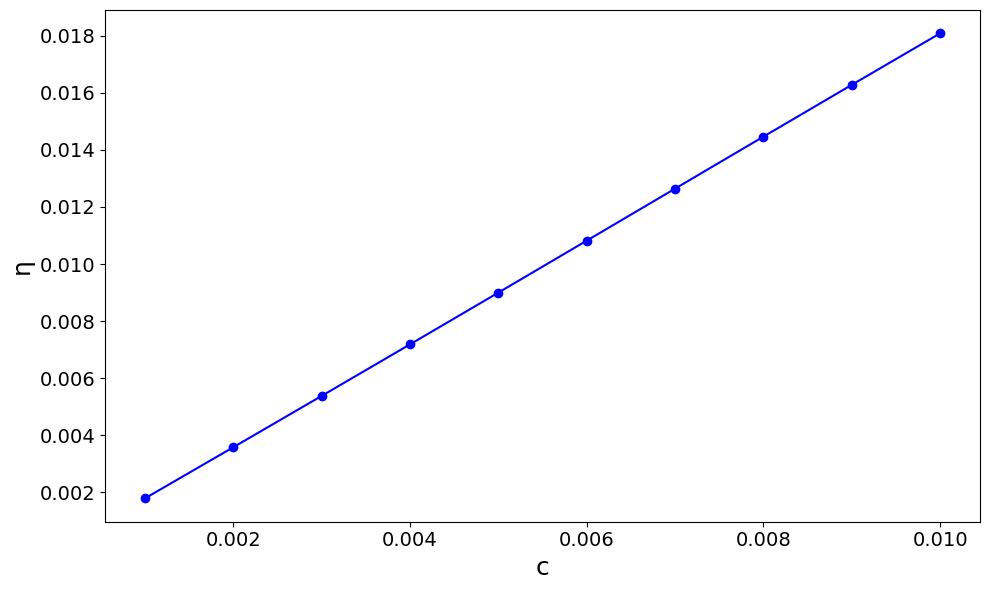

In [5]:
# Scan over c
c_vals = np.linspace(0.001,0.01, 10)
efficiencies_c = []
power_c = []
n_max = 10
print("Starting efficiency calculations for different values of c...")
for c in c_vals:
    sim_results = QSE(10,200, 0.1, n_max, c,300)
    efficiency = sim_results['efficiency']
    power = sim_results['power']
    efficiencies_c.append(efficiency if efficiency is not None else np.nan)
    power_c.append(power if power is not None else np.nan)
c_max = c_vals[np.nanargmax(efficiencies_c)]
print("Max efficiency is obtained at c = ", c_max)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(c_vals, efficiencies_c, marker='o', linestyle='-', color='b', label='Efficiency')
#ax.plot(c_vals, power_c, marker='o', linestyle='-', color='b', label='Power')
ax.set_xlabel("c", fontsize=18)
ax.set_ylabel('η', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('c_vs_eff_th.pdf', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()



Starting efficiency calculations for different values of T_kelvin...


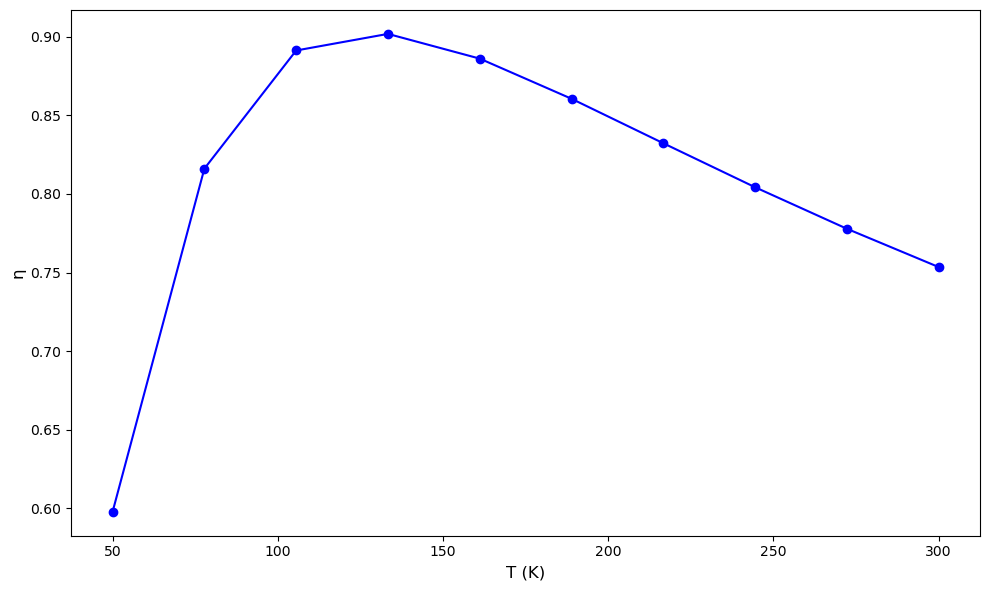

In [279]:
# Scan over T_kelvin
T_kelvin = np.linspace(50, 300, 10)
efficiencies_T = []
t_max = 10

print("Starting efficiency calculations for different values of T_kelvin...")
for T in T_kelvin:
    sim_results = QSE(t_max,T, 0.1, n_max, c_max,10)
    efficiency = sim_results['efficiency']
    efficiencies_T.append(efficiency if efficiency is not None else np.nan)
T_max = T_kelvin[np.nanargmax(efficiencies_T)]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(T_kelvin, efficiencies_T, marker='o', linestyle='-', color='b', label='Engine Efficiency')
ax.set_xlabel("T (K)", fontsize=12)
ax.set_ylabel('η', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('T_vs_eff_th.pdf', dpi=300, bbox_inches='tight')
plt.show()




Starting efficiency calculations for different values of gamma_0...
Max efficiency is obtained at gamma_0 =  0.06000000000000001


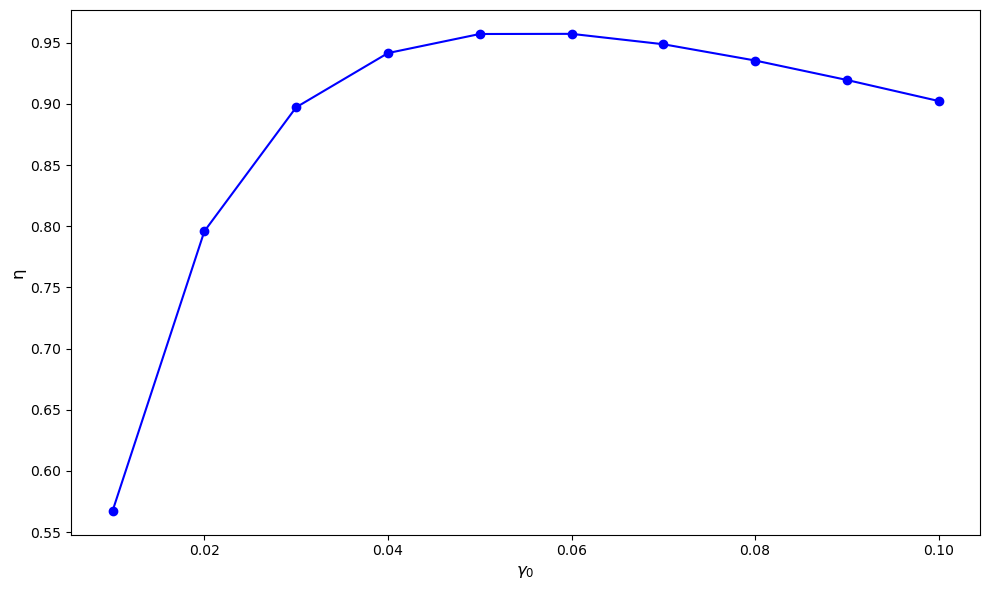

In [280]:
# Scan over gamma_0
gamma_vals = np.linspace(0.01, 0.1, 10)
efficiencies_gamma = []

print("Starting efficiency calculations for different values of gamma_0...")
for gamma in gamma_vals:
    sim_results = QSE(t_max,T_max, gamma, n_max, c_max,300)
    efficiency = sim_results['efficiency']
    efficiencies_gamma.append(efficiency if efficiency is not None else np.nan)
gamma_max = gamma_vals[np.nanargmax(efficiencies_gamma)]
print("Max efficiency is obtained at gamma_0 = ", gamma_max)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(gamma_vals, efficiencies_gamma, marker='o', linestyle='-', color='b', label='Engine Efficiency')
ax.set_xlabel(r"$\gamma_0$", fontsize=12)
ax.set_ylabel('η', fontsize=12)
plt.savefig('gamma0_vs_eff_th.pdf', dpi=300, bbox_inches='tight')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [281]:

res = QSE(100,T_max, gamma_max, 10, c_max,100)


In [282]:
res["efficiency"]

0.4448685920559249

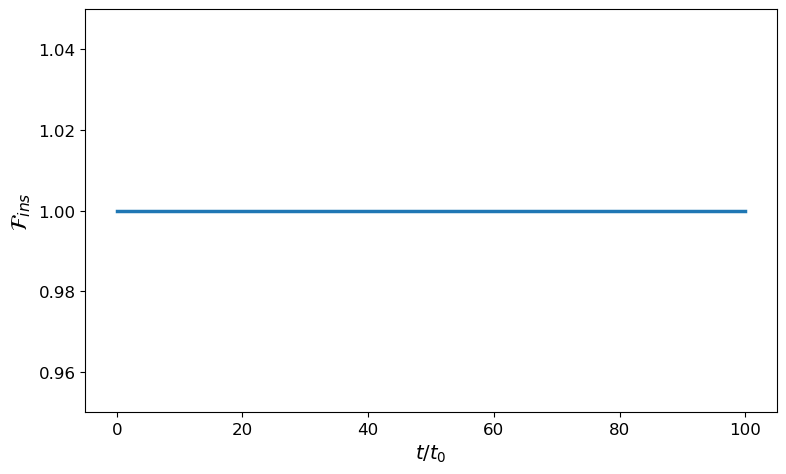

In [283]:
################################
# Result for optimal params(t_max, T_kelvin, gamma_0, n, c,time_step):
################################
# -----------FIDELITY INSERTION----------

fid_ins = res["insertion"]["fidelities"]
U_ins = res["insertion"]["U"]
F_ins = res["insertion"]["F"]
S_ins = res["insertion"]["S"]
U_qins = res["quasistatic"]["U"]
F_qins = res["quasistatic"]["F"]
S_qins = res["quasistatic"]["S"]
t_ins = res["insertion"]["times"]

lw=2.5 #line width
plt.figure(figsize=(8, 5))
plt.plot(t_ins, fid_ins, linewidth = lw)
plt.savefig('fidelity_ins_speed.pdf', dpi=300, bbox_inches='tight')
plt.xlabel(r"$t/t_0$", fontsize=14)
plt.ylabel(r"$\mathcal{F}_{ins}$", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.ylim([0.9999999999999999,1])
plt.savefig('fidelity_ins_th.pdf', dpi=300, bbox_inches='tight')
plt.show()

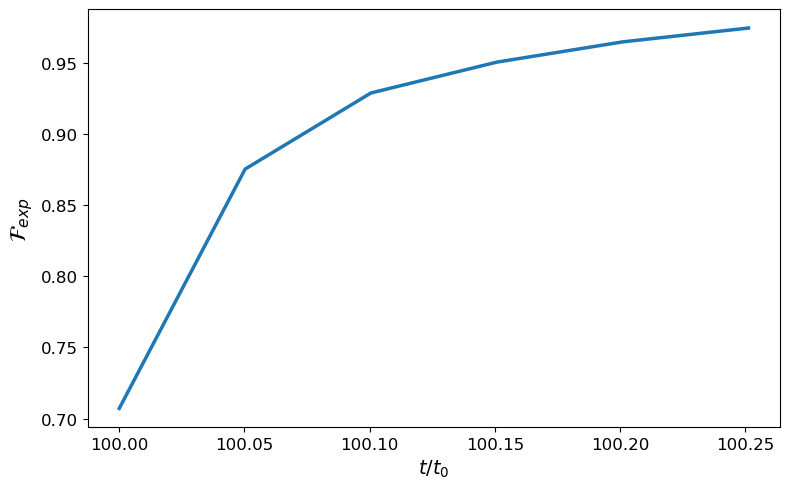

In [284]:
# -----------FIDELITY EXPANSION----------
fid_exp = res["expansion"]["fidelities"]
U_exp = res["expansion"]["U"]
F_exp = res["expansion"]["F"]
S_exp = res["expansion"]["S"]

t_exp = res["expansion"]["times"]

lw=2.5 #line width
plt.figure(figsize=(8, 5))
plt.plot(t_exp, fid_exp, linewidth = lw)
plt.savefig('fidelity_exp.pdf', dpi=300, bbox_inches='tight')
plt.xlabel(r"$t/t_0$", fontsize=14)
plt.ylabel(r"$\mathcal{F}_{exp}$", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('fidelity_exp_th.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [285]:
res["efficiency"]

0.4448685920559249

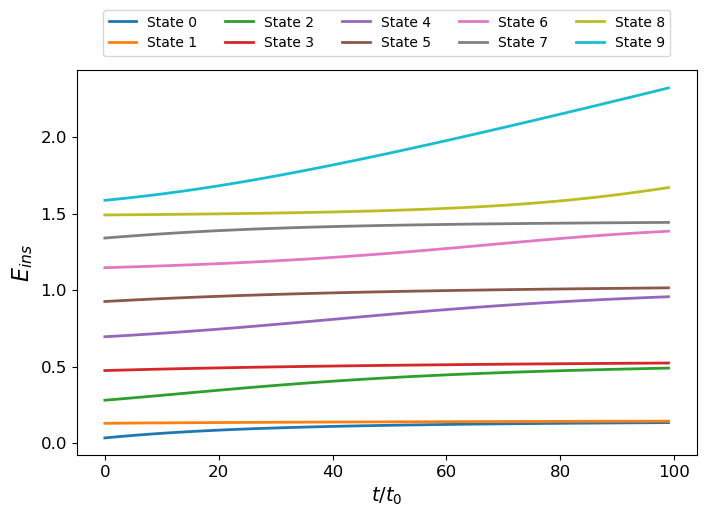

In [286]:
# -----------ENERGY LEVELS INSERTION----------
e_ins = res["insertion"]["e_levels"]
t_ins = res["insertion"]["times"]
e_ins_array = np.array(e_ins)
plt.figure(figsize=(8, 5))
lw = 2
n_levels = e_ins_array.shape[1]
for i in range(n_levels):
    plt.plot(t_ins[:-1], e_ins_array[:, i], linewidth=lw, label=f'State {i}')

plt.xlabel(r"$t/t_0$", fontsize=14)
plt.ylabel(r"$E_{ins}$", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), ncol=5, fontsize=10)
plt.savefig('el_ins_th.pdf', dpi=300, bbox_inches='tight')
#plt.ylim([0,5])
plt.show()

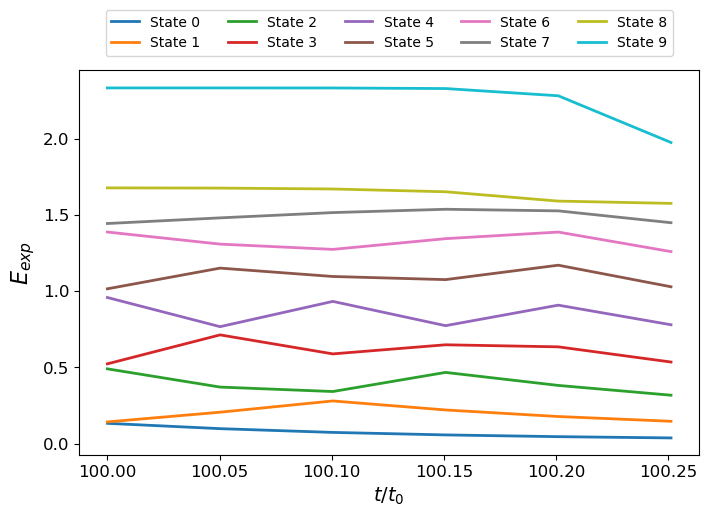

In [287]:
# -----------ENERGY LEVELS EXPANSION----------
t_exp = res["expansion"]["times"]
e_exp = res["expansion"]["e_levels"][0:len(t_exp)]
e_exp_array = np.array(e_exp)
plt.figure(figsize=(8, 5))
lw = 2
n_levels = e_exp_array.shape[1]
for i in range(n_levels):
    plt.plot(t_exp, e_exp_array[:, i], linewidth=lw, label=f'State {i}')

plt.xlabel(r"$t/t_0$", fontsize=14)
plt.ylabel(r"$E_{exp}$", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), ncol=5, fontsize=10)
plt.savefig('el_exp_th.pdf', dpi=300, bbox_inches='tight')
plt.ylim()
plt.show()

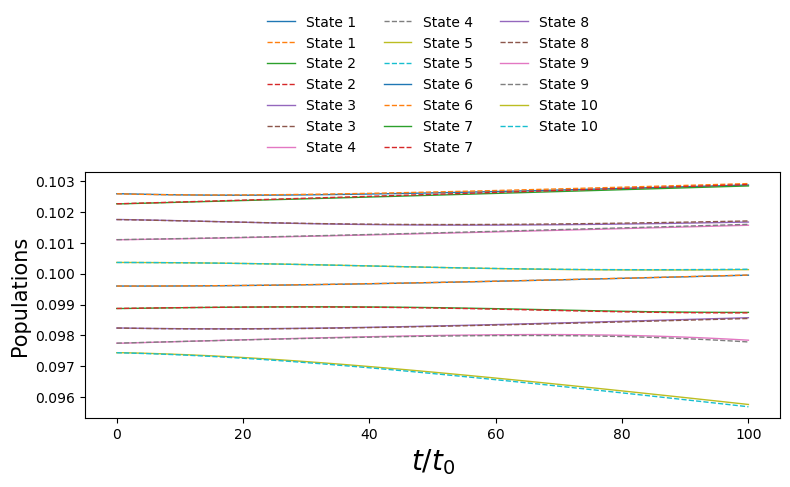

In [288]:
plt.figure(figsize=(8, 5))
pop_ins = res["insertion"]["populations"]
pop_qins = res["quasistatic"]["populations"]
pop_ins = np.array(pop_ins)
pop_qins = np.array(pop_qins)
labels = [f"State {i+1}" for i in range(pop_ins.shape[1])]

for i in range(pop_ins.shape[1]):
    plt.plot(t_ins, pop_ins[:, i], linewidth=1, label=labels[i])
    plt.plot(t_ins, pop_qins[:, i], linestyle='--', linewidth=1.0, label=labels[i])
plt.xlabel(r'$t/t_0$', fontsize=20)
plt.ylabel(r'Populations', fontsize=15)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), ncol=3, fontsize=10, frameon=False)
plt.tight_layout()
plt.savefig('pop_ins_th.pdf', dpi=300, bbox_inches='tight')
plt.show()


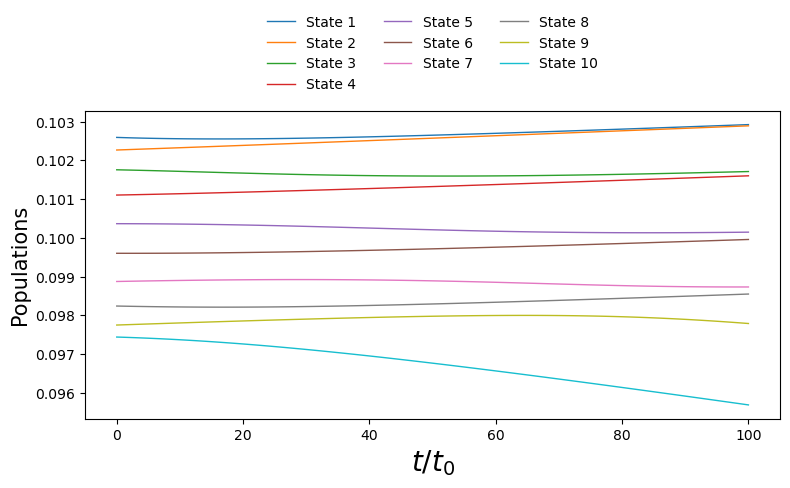

In [289]:
plt.figure(figsize=(8, 5))
pop_ins = res["insertion"]["populations"]
pop_qins = res["quasistatic"]["populations"]
pop_ins = np.array(pop_ins)
pop_qins = np.array(pop_qins)
labels = [f"State {i+1}" for i in range(pop_ins.shape[1])]

for i in range(pop_ins.shape[1]):
    plt.plot(t_ins, pop_qins[:, i], linestyle='-', linewidth=1.0, label=labels[i])
plt.xlabel(r'$t/t_0$', fontsize=20)
plt.ylabel(r'Populations', fontsize=15)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), ncol=3, fontsize=10, frameon=False)
plt.tight_layout()
plt.savefig('pop_qins_th.pdf', dpi=300, bbox_inches='tight')
plt.show()


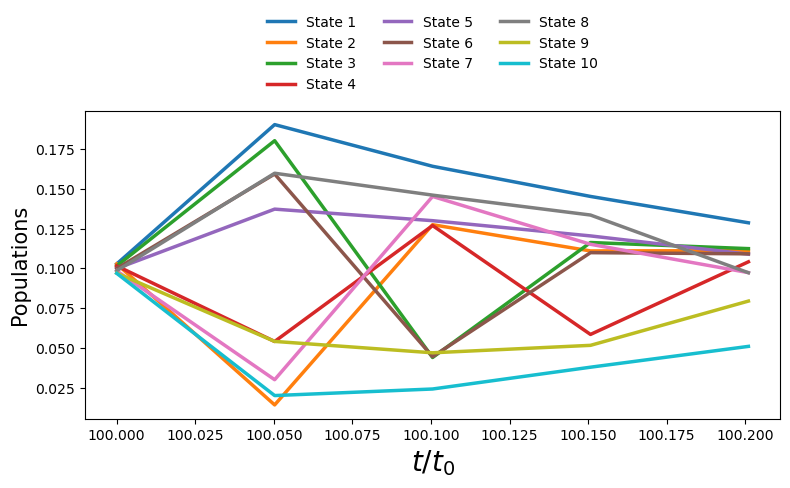

In [290]:
# -----------POPULATIONS EXPANSION----------
plt.figure(figsize=(8, 5))
pop_exp = res["expansion"]["populations"][0:-1]
pop_exp = np.array(pop_exp)
labels = [f"State {i+1}" for i in range(pop_exp.shape[1])]

for i in range(pop_exp.shape[1]):
    plt.plot(t_exp[0:-1], pop_exp[:, i], linewidth=2.5, label=labels[i])
plt.xlabel(r'$t/t_0$', fontsize=20)
plt.ylabel(r'Populations', fontsize=15)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), ncol=3, fontsize=10, frameon=False)
plt.tight_layout()
plt.savefig('pop_exp_th.pdf', dpi=300, bbox_inches='tight')
plt.show()


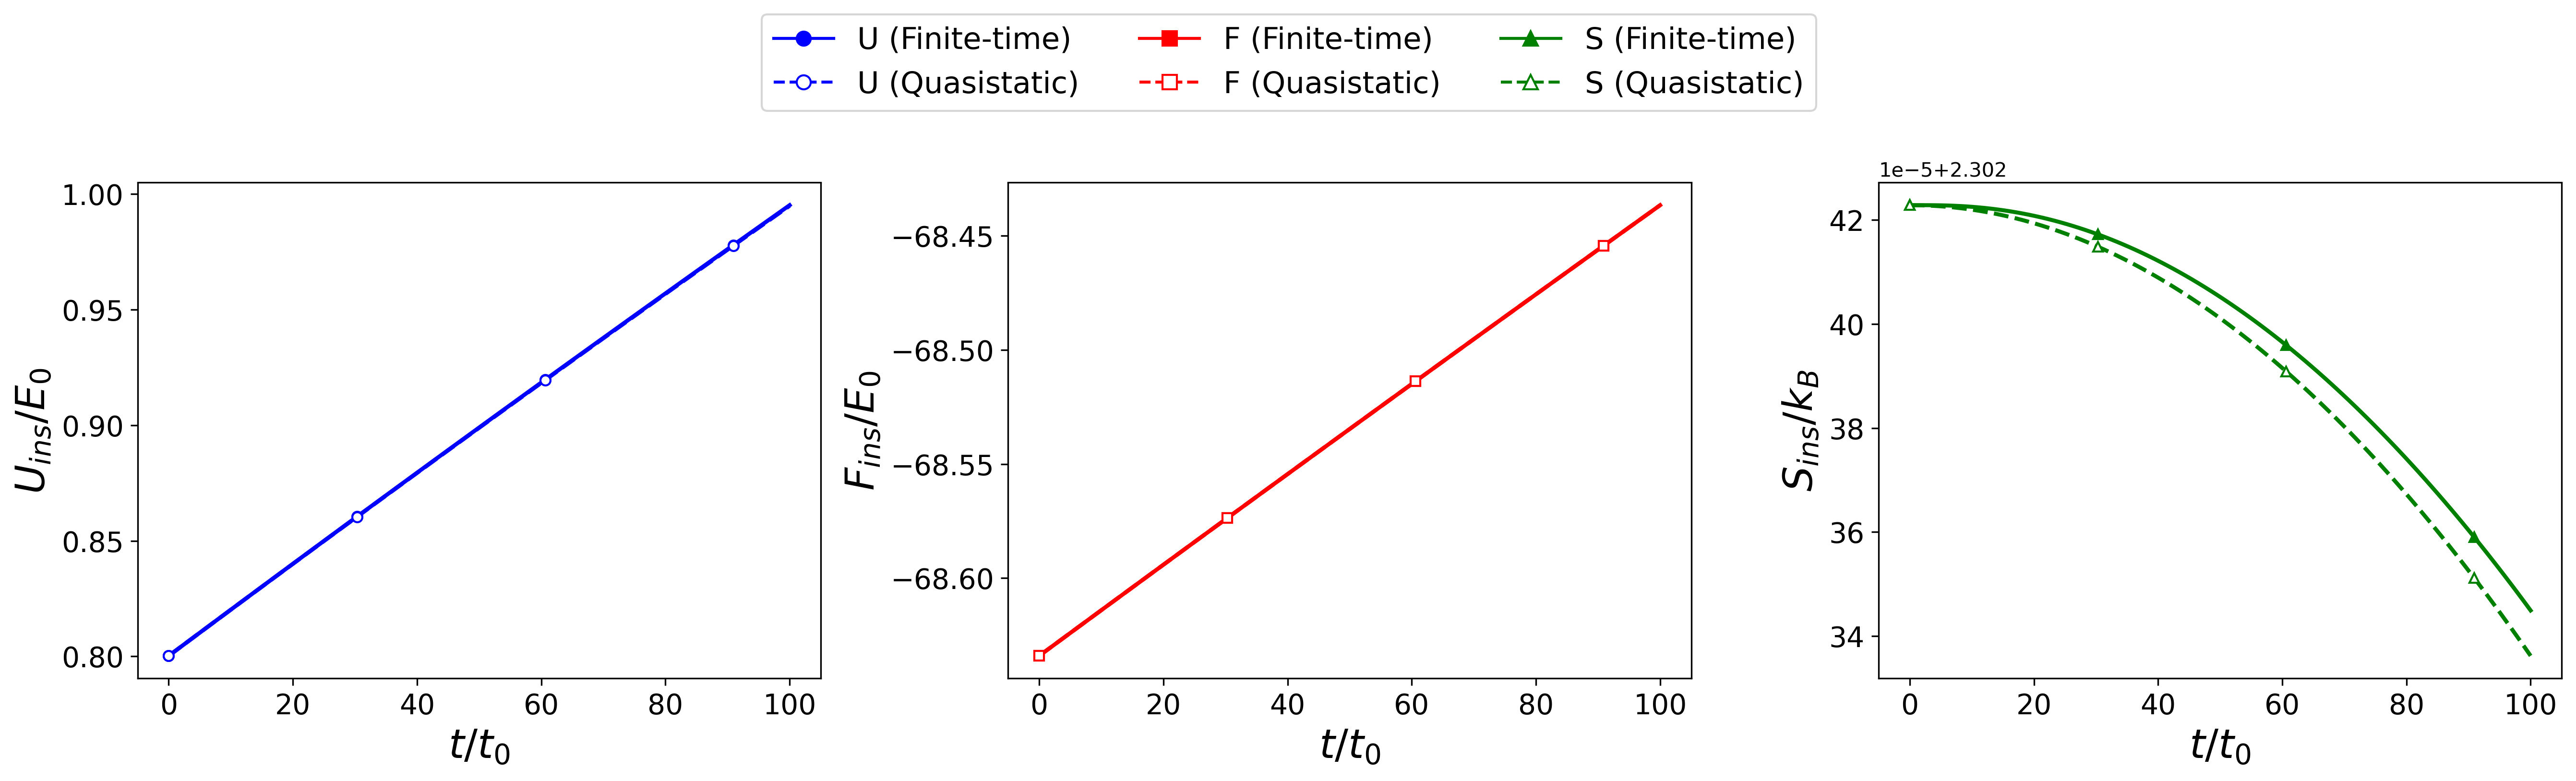

In [291]:
# -----------U-F-S-INSERTION----------
fig, (ax_u, ax_f, ax_s) = plt.subplots(1, 3, figsize=(18, 5), dpi=300)
plt.subplots_adjust(wspace=0.3, bottom=0.3)
plt.subplots_adjust(wspace=0.3, bottom=0.3)
# U
ax_u.plot(t_ins, U_ins, color="blue", linestyle='-', marker="o", markevery=30, markersize=5, linewidth=2, markerfacecolor='blue', markeredgecolor='blue')
ax_u.plot(t_ins, U_qins, color="blue", linestyle='--', marker="o", markevery=30, markersize=5, linewidth=2, markerfacecolor="white", markeredgecolor="blue")
ax_u.set_xlabel(r'$t/t_0$', fontsize=20)
ax_u.set_ylabel(r'$U_{ins}/E_0$', fontsize=20)
ax_u.tick_params(axis='both', which='major', labelsize=14)
# F
ax_f.plot(t_ins, F_ins, color="red", linestyle='-', marker="s", markevery=30, markersize=5, linewidth=2, markerfacecolor="red", markeredgecolor="red")
ax_f.plot(t_ins, F_qins, color="red", linestyle='--', marker="s", markevery=30, markersize=5, linewidth=2, markerfacecolor="white", markeredgecolor="red")
ax_f.set_xlabel(r'$t/t_0$', fontsize=20)
ax_f.set_ylabel(r'$F_{ins}/E_0$', fontsize=20)
ax_f.tick_params(axis='both', which='major', labelsize=14)
# S
ax_s.plot(t_ins, S_ins, color="green", linestyle='-', marker="^", markevery=30, markersize=5, linewidth=2, markerfacecolor="green", markeredgecolor="green")
ax_s.plot(t_ins, S_qins, color="green", linestyle='--', marker="^", markevery=30, markersize=5, linewidth=2, markerfacecolor="white", markeredgecolor="green")
ax_s.set_xlabel(r'$t/t_0$', fontsize=20)
ax_s.set_ylabel(r'$S_{ins}/k_B$', fontsize=20)
ax_s.tick_params(axis='both', which='major', labelsize=14)
# --- Legend ---
legend_elements = []
for name, color, marker in [("U", "blue", "o"), ("F", "red", "s"), ("S", "green", "^")]:
    legend_elements += [
        Line2D([0], [0], color=color, marker=marker, markersize=7,
               markerfacecolor=color, markeredgecolor=color, linestyle='-', label=f'{name} (Finite-time)'),
        Line2D([0], [0], color=color, marker=marker, markersize=7,
               markerfacecolor='white', markeredgecolor=color, linestyle='--', label=f'{name} (Quasistatic)')
    ]

fig.legend(handles=legend_elements,
           loc='lower center',
           bbox_to_anchor=(0.5, 0.92),
           ncol=3,
           fontsize=15,
           frameon=True)

# --- Final layout & save ---
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.savefig('ufs_ins_th.pdf', dpi=600, bbox_inches='tight')
plt.show()

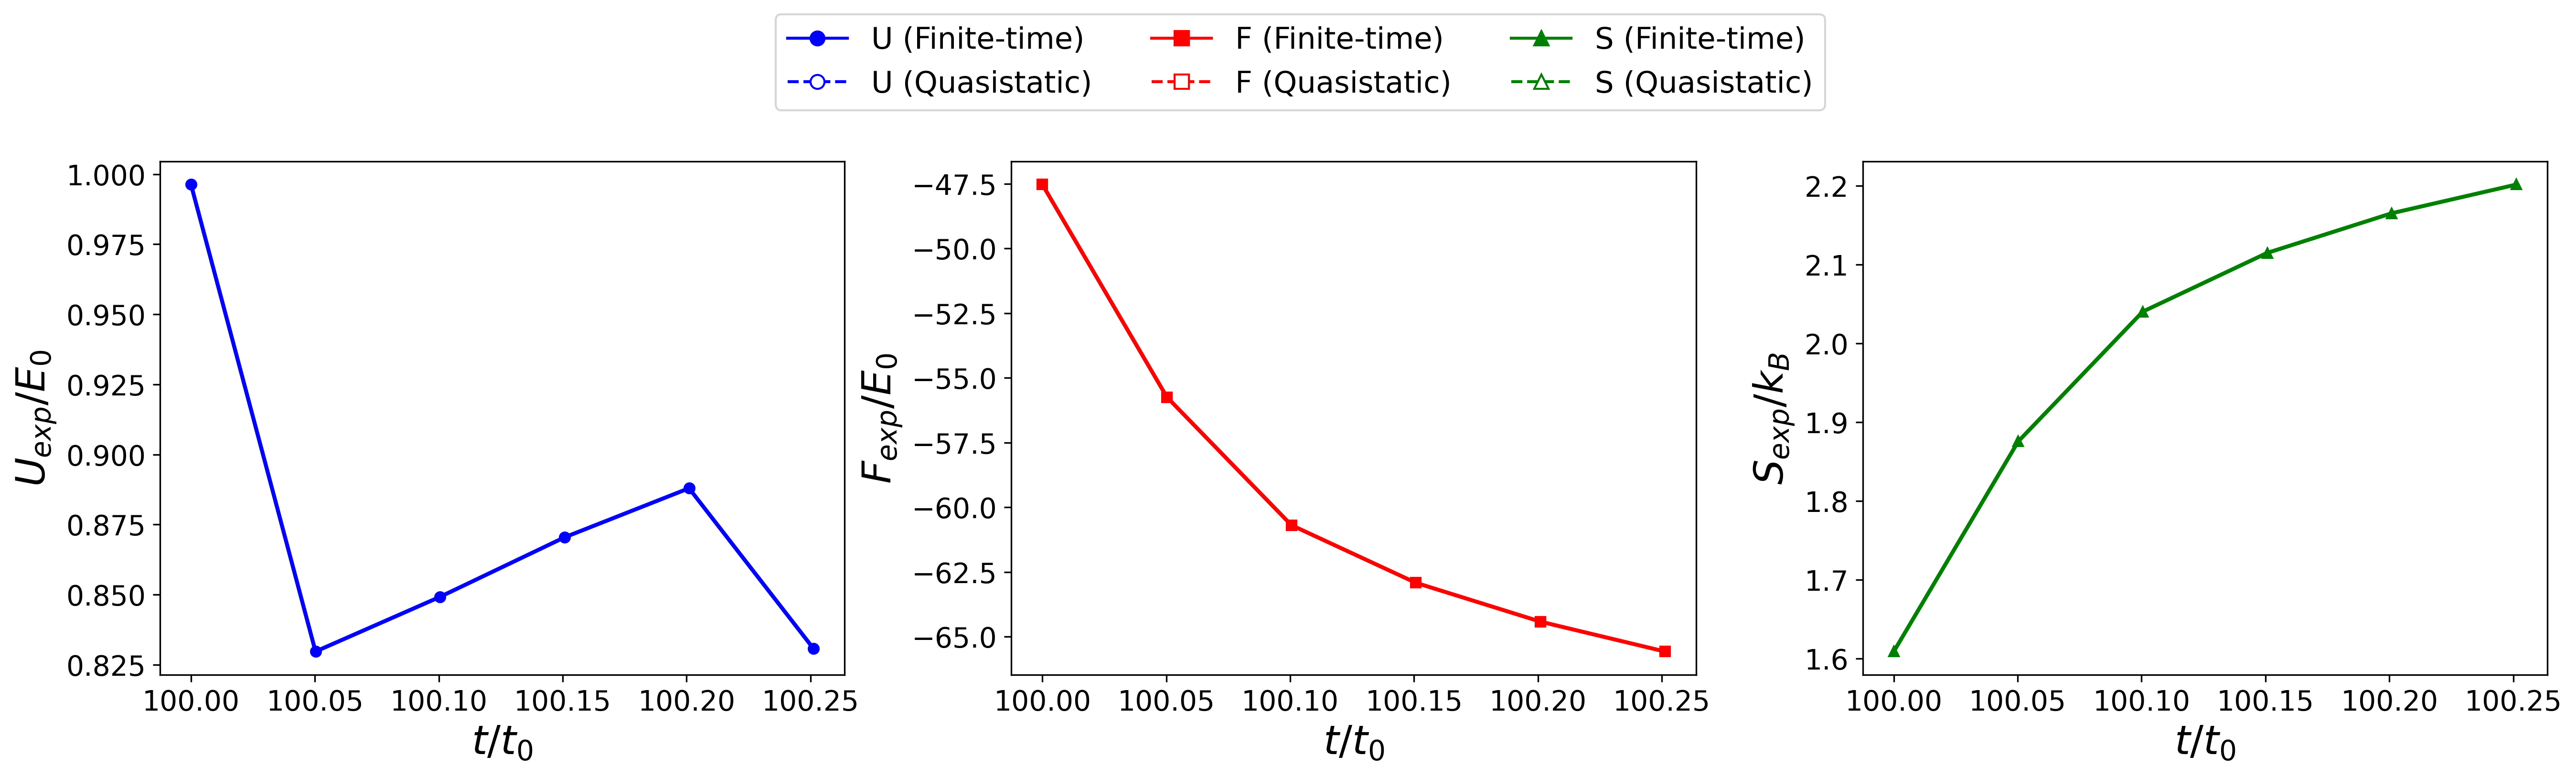

In [292]:
# -----------U-F-S-EXPANSION----------
U_exp = res["expansion"]["U"]
F_exp = res["expansion"]["F"]
S_exp = res["expansion"]["S"]

t_exp = res["expansion"]["times"]
fig, (ax_u, ax_f, ax_s) = plt.subplots(1, 3, figsize=(18, 5), dpi=300)
plt.subplots_adjust(wspace=0.3, bottom=0.3)
plt.subplots_adjust(wspace=0.3, bottom=0.3)
# U
ax_u.plot(t_exp, U_exp, color="blue", linestyle='-', marker="o", markevery=1, markersize=5, linewidth=2, markerfacecolor='blue', markeredgecolor='blue')
ax_u.set_xlabel(r'$t/t_0$', fontsize=20)
ax_u.set_ylabel(r'$U_{exp}/E_0$', fontsize=20)
ax_u.tick_params(axis='both', which='major', labelsize=14)
# F
ax_f.plot(t_exp, F_exp, color="red", linestyle='-', marker="s", markevery=1, markersize=5, linewidth=2, markerfacecolor="red", markeredgecolor="red")
ax_f.set_xlabel(r'$t/t_0$', fontsize=20)
ax_f.set_ylabel(r'$F_{exp}/E_0$', fontsize=20)
ax_f.tick_params(axis='both', which='major', labelsize=14)
# S
ax_s.plot(t_exp, S_exp, color="green", linestyle='-', marker="^", markevery=1, markersize=5, linewidth=2, markerfacecolor="green", markeredgecolor="green")
ax_s.set_xlabel(r'$t/t_0$', fontsize=20)
ax_s.set_ylabel(r'$S_{exp}/k_B$', fontsize=20)
ax_s.tick_params(axis='both', which='major', labelsize=14)
# --- Legend ---
legend_elements = []
for name, color, marker in [("U", "blue", "o"), ("F", "red", "s"), ("S", "green", "^")]:
    legend_elements += [
        Line2D([0], [0], color=color, marker=marker, markersize=7,
               markerfacecolor=color, markeredgecolor=color, linestyle='-', label=f'{name} (Finite-time)'),
        Line2D([0], [0], color=color, marker=marker, markersize=7,
               markerfacecolor='white', markeredgecolor=color, linestyle='--', label=f'{name} (Quasistatic)')
    ]

fig.legend(handles=legend_elements,
           loc='lower center',
           bbox_to_anchor=(0.5, 0.92),
           ncol=3,
           fontsize=15,
           frameon=True)

# --- Final layout & save ---
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.savefig('ufs_exp_th.pdf', dpi=600, bbox_inches='tight')
plt.show()

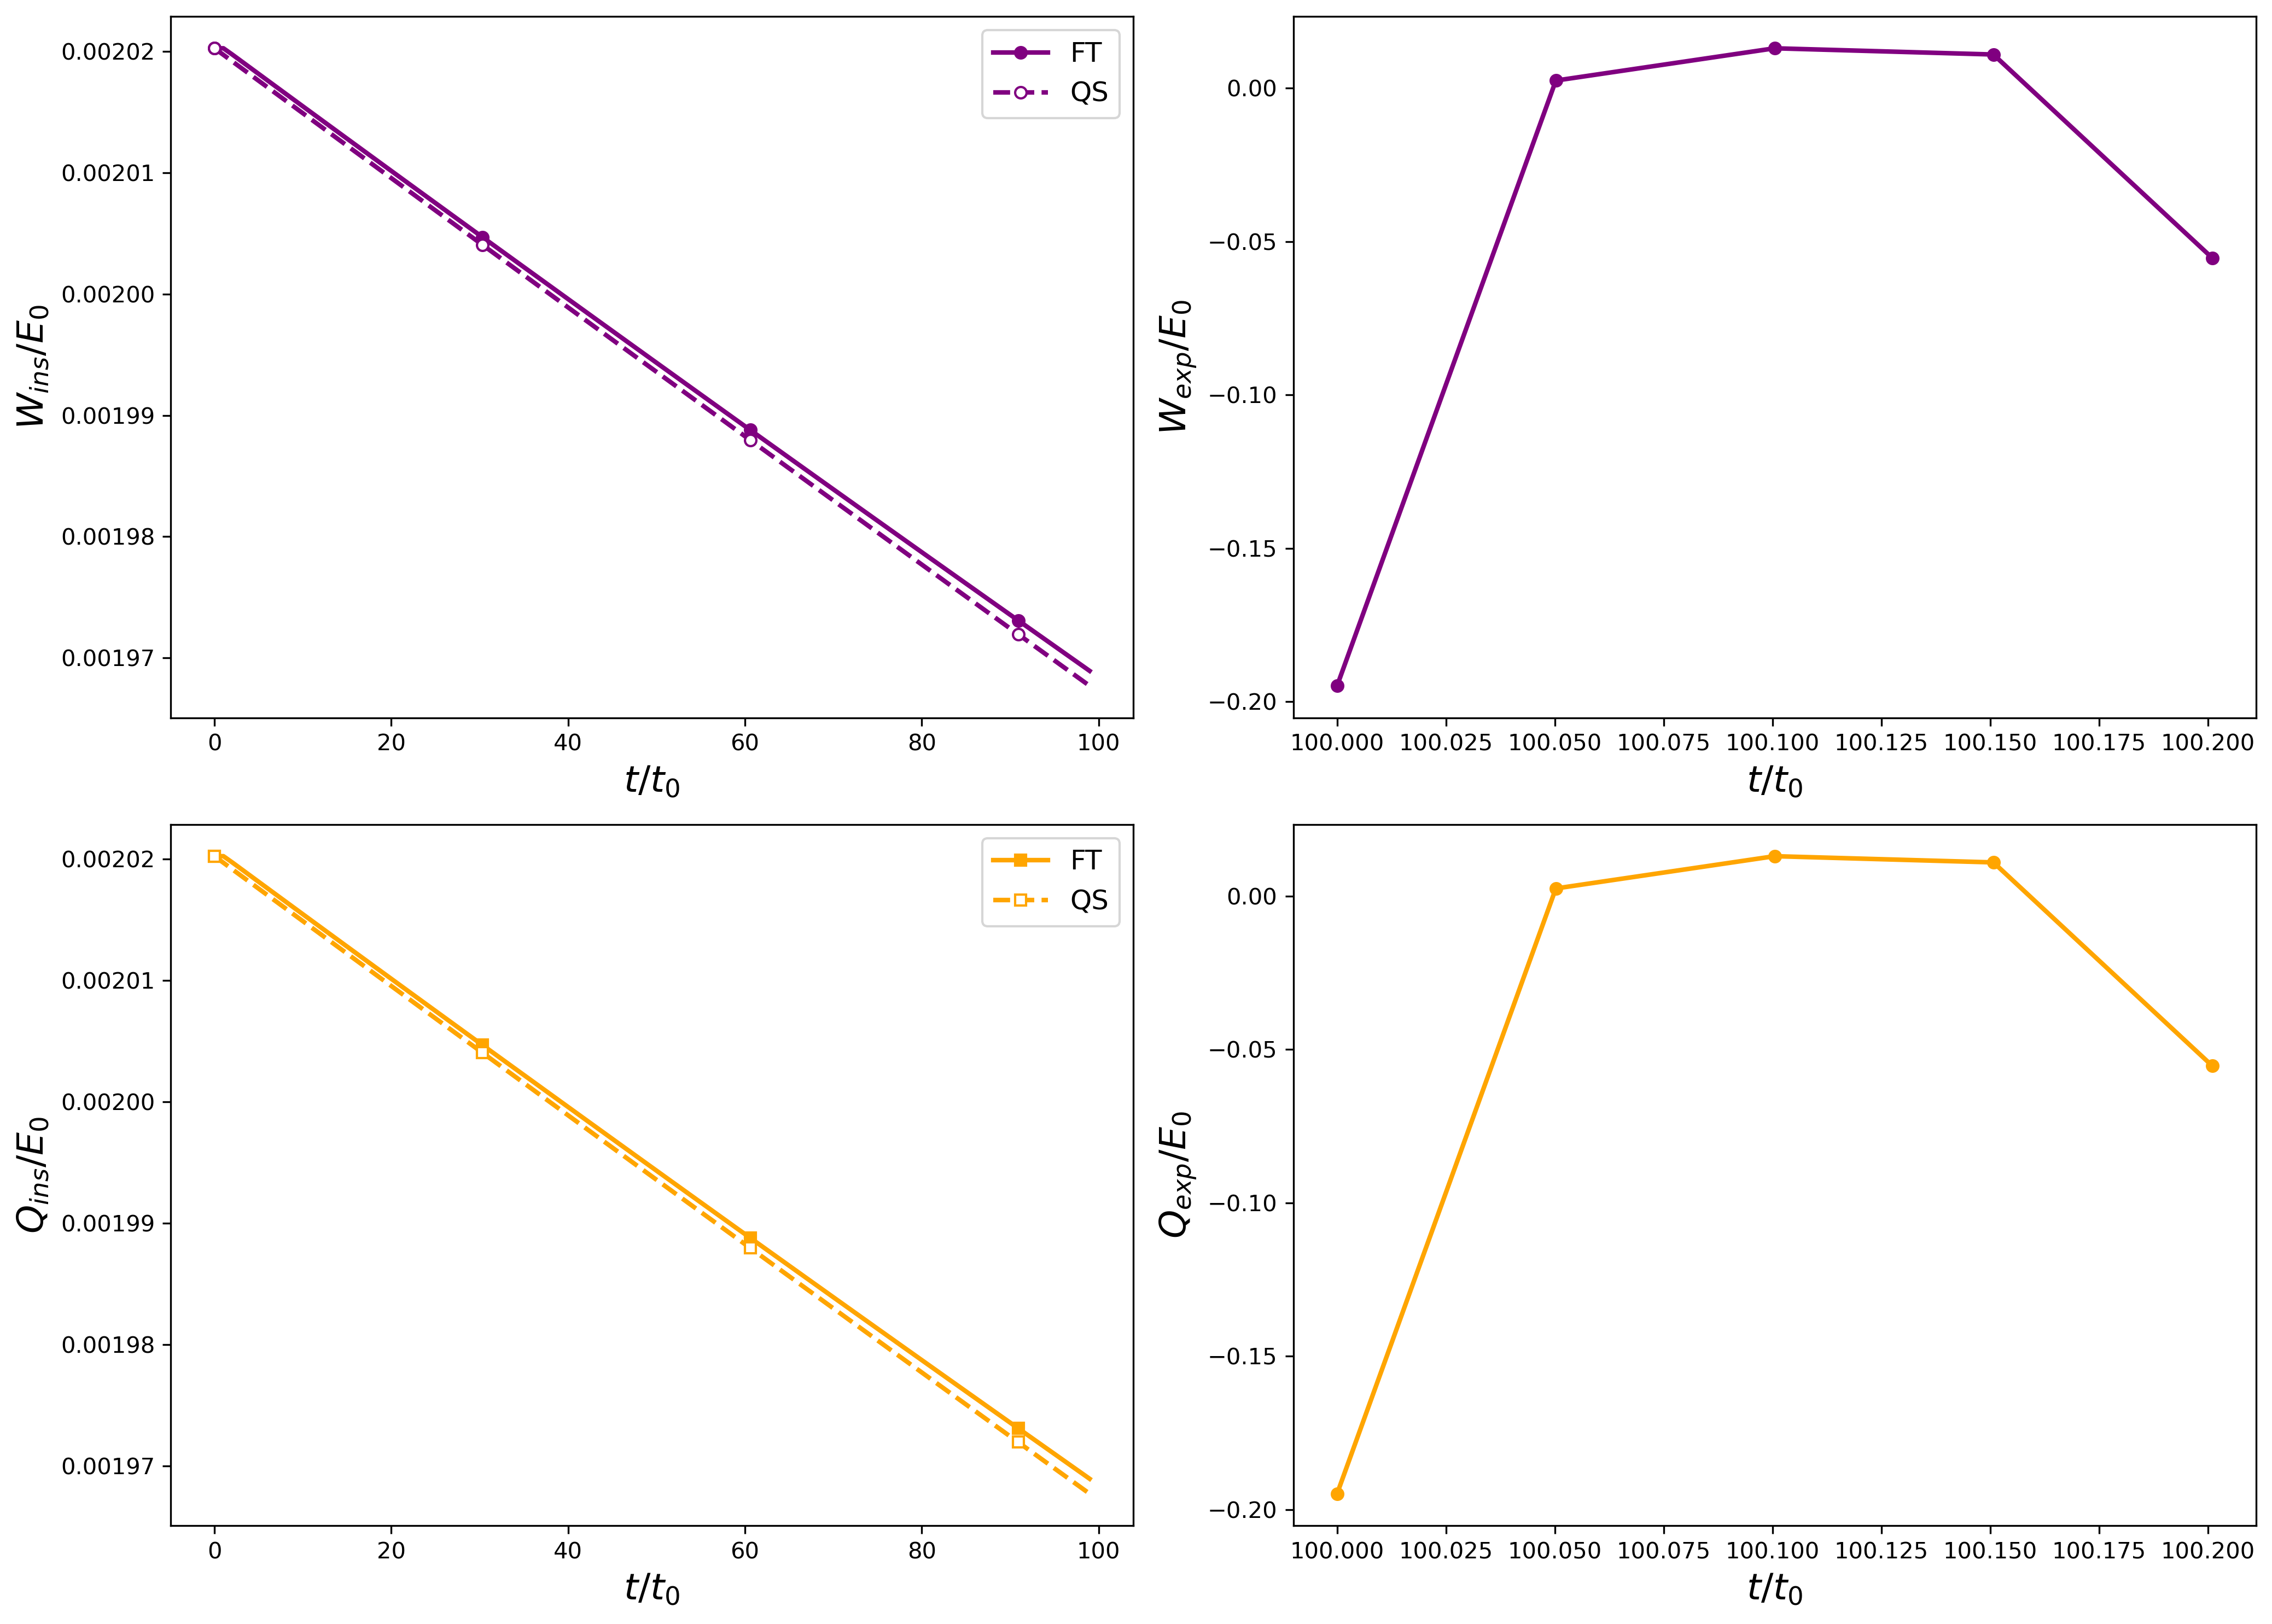

In [293]:
# -----------WORK-HEAT----------
W_ins = res["insertion"]["W"]
W_qins = res["quasistatic"]["W"]
W_exp = res["expansion"]["W"]
Q_ins = res["insertion"]["W"]
Q_qins = res["quasistatic"]["W"]
Q_exp = res["expansion"]["W"]
fig, axs = plt.subplots(2, 2, figsize=(14, 10), dpi=300)
plt.subplots_adjust(wspace=0.3, hspace=0.4, bottom=0.1)

# Top-left: W insertion + quasistatic
ax = axs[0, 0]
ax.plot(t_ins[0:-1], W_ins, color="purple", linestyle='-', marker="o", markevery=30, markersize=5,
        linewidth=2, markerfacecolor='purple', markeredgecolor='purple', label='FT')
ax.plot(t_ins[0:-1], W_qins, color="purple", linestyle='--', marker="o", markevery=30, markersize=5,
        linewidth=2, markerfacecolor='white', markeredgecolor='purple', label='QS')
ax.set_xlabel(r'$t/t_0$', fontsize=16)
ax.set_ylabel(r'$W_{ins}/E_0$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=10)

ax.legend(fontsize=12)

# Top-right: W expansion
ax = axs[0, 1]
ax.plot(t_exp[0:-1], W_exp, color="purple", linestyle='-', marker="o", markevery=1, markersize=5,
        linewidth=2, markerfacecolor='purple', markeredgecolor='purple')
ax.set_xlabel(r'$t/t_0$', fontsize=16)
ax.set_ylabel(r'$W_{exp}/E_0$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=10)


# Bottom-left: Q insertion + quasistatic
ax = axs[1, 0]
ax.plot(t_ins[0:-1], Q_ins, color="orange", linestyle='-', marker="s", markevery=30, markersize=5,
        linewidth=2, markerfacecolor='orange', markeredgecolor='orange', label='FT')
ax.plot(t_ins[0:-1], Q_qins, color="orange", linestyle='--', marker="s", markevery=30, markersize=5,
        linewidth=2, markerfacecolor='white', markeredgecolor='orange', label='QS')
ax.set_xlabel(r'$t/t_0$', fontsize=16)
ax.set_ylabel(r'$Q_{ins}/E_0$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.legend(fontsize=12)

# Bottom-right: Q expansion
ax = axs[1, 1]
ax.plot(t_exp[0:-1], Q_exp, color="orange", linestyle='-', marker="o", markevery=1, markersize=5,
        linewidth=2, markerfacecolor='orange', markeredgecolor='orange')
ax.set_xlabel(r'$t/t_0$', fontsize=16)
ax.set_ylabel(r'$Q_{exp}/E_0$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=10)


plt.tight_layout()
plt.savefig('W_Q_th.pdf', dpi=600, bbox_inches='tight')
plt.show()


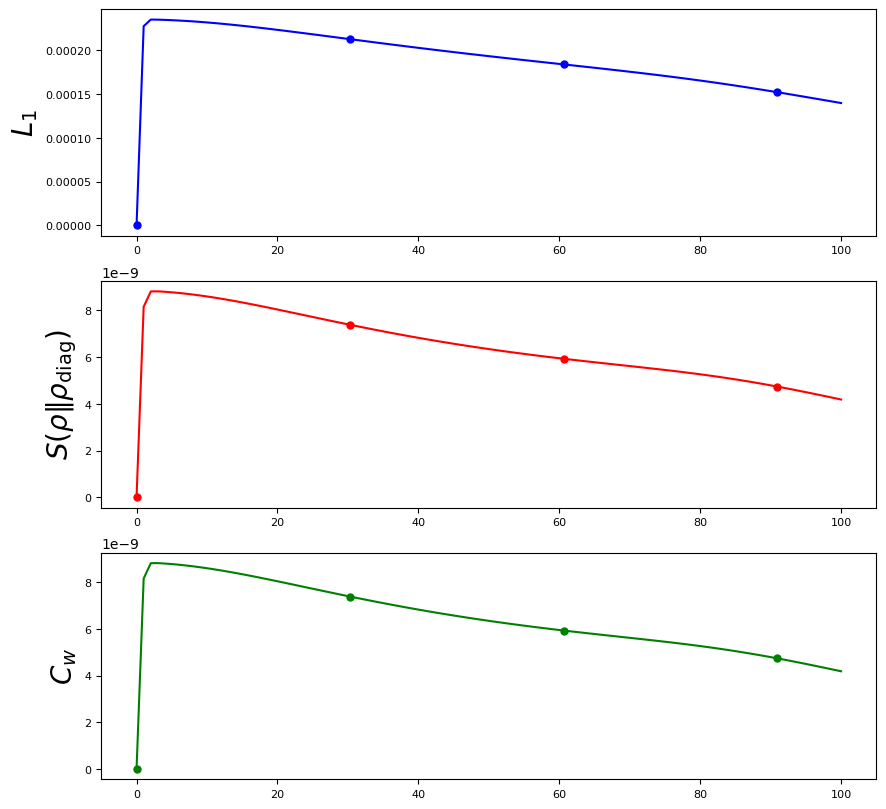

In [294]:
# -----------COHERENCE INSERTION----------

l1_ins = res["insertion"]["coherence"]["l1"]
re = res["insertion"]["coherence"]["rel_entropy"]
cw = res["insertion"]["coherence"]["C_w"]
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(3, 1, 1)
ax2 = plt.subplot(3, 1, 2)
ax3 = plt.subplot(3, 1, 3)
ax1.plot(t_ins,l1_ins,color="blue", marker="o", linestyle="-", markersize=5, markevery=30)
ax1.set_ylabel(r'$L_1$', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=8)

ax2.plot(t_ins,re,color="red", marker="o", linestyle="-", markersize=5, markevery=30)
ax2.set_ylabel(r'$S(\rho \| \rho_{\mathrm{diag}})$', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=8)

ax3.plot(t_ins,re,color="green", marker="o", linestyle="-", markersize=5, markevery=30)
ax3.set_ylabel(r'$C_w$', fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=8)
plt.savefig('coh_ins_th.pdf', dpi=600, bbox_inches='tight')


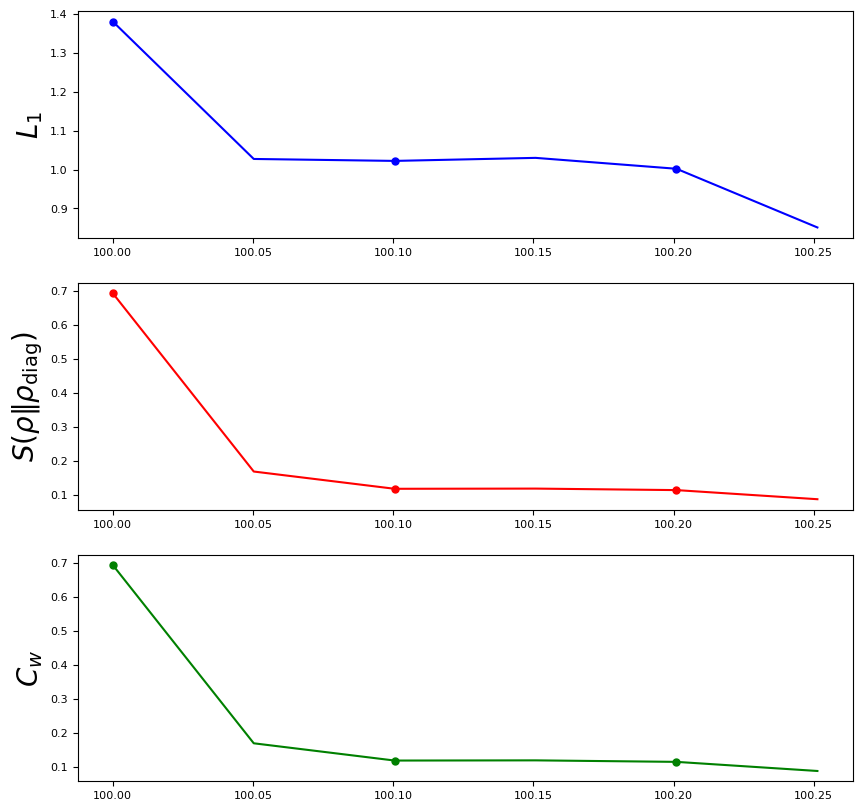

In [296]:
# -----------COHERENCE EXPANSION----------

l1_exp = res["expansion"]["coherence"]["l1"]
re_exp = res["expansion"]["coherence"]["rel_entropy"]
cw_exp = res["expansion"]["coherence"]["C_w"]
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(3, 1, 1)
ax2 = plt.subplot(3, 1, 2)
ax3 = plt.subplot(3, 1, 3)
ax1.plot(t_exp,l1_exp,color="blue", marker="o", linestyle="-", markersize=5, markevery=2)
ax1.set_ylabel(r'$L_1$', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=8)

ax2.plot(t_exp,re_exp,color="red", marker="o", linestyle="-", markersize=5, markevery=2)
ax2.set_ylabel(r'$S(\rho \| \rho_{\mathrm{diag}})$', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=8)

ax3.plot(t_exp,re_exp,color="green", marker="o", linestyle="-", markersize=5, markevery=2)
ax3.set_ylabel(r'$C_w$', fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=8)
plt.savefig('coh_exp_th.pdf', dpi=600, bbox_inches='tight')

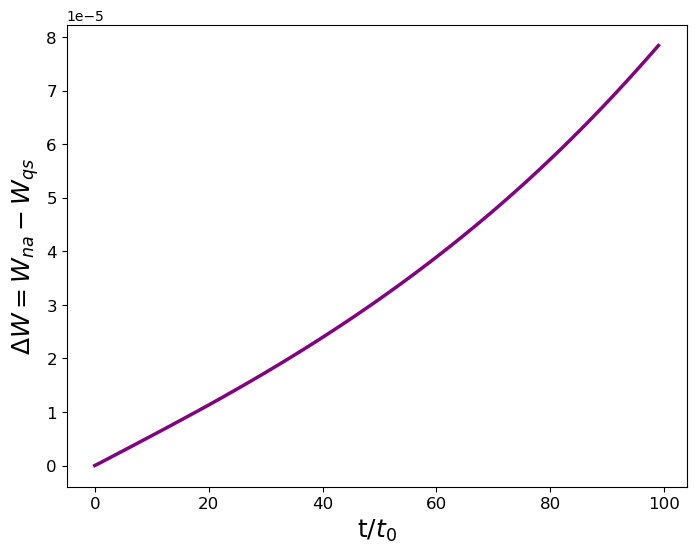

In [297]:
# -----------W_NA - W_QS----------
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
ΔW_ins_ideal = [w_ins - w_qins for w_ins, w_qins in zip(W_ins, W_qins)]
ax1.plot(t_ins[:-1], np.cumsum(ΔW_ins_ideal).tolist(),color ="purple",linewidth = 2.5)
ax1.set_xlabel('t/$t_0$', fontsize=18)
ax1.set_ylabel(r'$\Delta W = W_{na} - W_{qs}$', fontsize=18)
ax1.tick_params(axis='both', labelsize=12)
plt.savefig('Wna-Wqs_th.pdf', dpi=600, bbox_inches='tight')

In [298]:
# --- FINAL CYCLE SUMMARY ---
thermo_ins = res['insertion']
thermo_exp = res['expansion']
eff = res["efficiency"]
delta_S_meas = thermo_exp['S'][0]-thermo_ins['S'][-1]
delta_F_meas = thermo_exp['F'][0]-thermo_ins['F'][-1]
delta_U_exp = thermo_exp['U'][-1] - thermo_exp['U'][0]
delta_F_exp = thermo_exp['F'][-1] - thermo_exp['F'][0]
delta_S_exp = thermo_exp['S'][-1] - thermo_exp['S'][0]
total_W_exp = sum(thermo_exp['W'])
total_Q_exp = sum(thermo_exp['Q'])
# if the barrier exit the box, the hamiltonian wont chnage, only kinetic part
# the energy reuqired to turn back to initial state
E_rem = (thermo_ins["U"][0]-thermo_exp["U"][-1])
E_meas = (thermo_exp["U"][0]-thermo_ins["U"][-1])
S_rem = (thermo_ins["S"][0]-thermo_exp["S"][-1])
F_rem = (thermo_ins["F"][0]-thermo_exp["F"][-1])


delta_U_lind = thermo_ins["U"][-1]-thermo_ins["U"][0]
delta_F_lind = thermo_ins["F"][-1]-thermo_ins["F"][0]
delta_S_lind = thermo_ins["S"][-1]-thermo_ins["S"][0]
total_W_lind = sum(thermo_ins["W"])
total_Q_lind = sum(thermo_ins["Q"])

print(f"\n\033[1mFull Cycle Results:\033[0m")
print("-" * 65)
print(f"{'Quantity':<20}{'Insertion':<15}{'Measurement':<15}{'Expansion':<15}{'Removal':<15}{'Total':<15}")
print(f"{'ΔU':<20}{delta_U_lind:<15.4f}{E_meas:<15.4f}{delta_U_exp:<15.4f}{E_rem:<15.4f}{(delta_U_lind + delta_U_exp+E_meas+E_rem):.4f}")
print(f"{'ΔF':<20}{delta_F_lind:<15.4f}{delta_F_meas:<15.4f}{delta_F_exp:<15.4f}{F_rem:<15.4f}{(delta_F_lind + delta_F_exp+delta_F_meas+F_rem):.4f}")
print(f"{'ΔS':<20}{delta_S_lind:<15.4f}{delta_S_meas:<15.4f}{delta_S_exp:<15.4f}{S_rem:<15.4f}{(delta_S_lind + delta_S_exp+delta_S_meas+S_rem):.4f}")
print(f"{'Total Work':<20}{total_W_lind:<15.4f}{0:<15.4f}{total_W_exp:<15.4f}{0:<15.4f}{(total_W_lind + total_W_exp):.4f}")
print(f"{'Total Heat':<20}{total_Q_lind:<15.4f}{E_meas:<15.4f}{total_Q_exp:<15.4f}{E_rem:<15.4f}{(total_Q_lind + total_Q_exp+E_meas+E_rem):.4f}")
print(f"\nEngine Efficiency = {eff:.6f}")


Full Cycle Results:
-----------------------------------------------------------------
Quantity            Insertion      Measurement    Expansion      Removal        Total          
ΔU                  0.1950         0.0011         -0.1655        -0.0305        0.0000
ΔF                  0.1974         20.9038        -18.0364       -3.0647        0.0000
ΔS                  -0.0001        -0.6931        0.5926         0.1006         0.0000
Total Work          0.1975         0.0000         -0.2239        0.0000         -0.0264
Total Heat          -0.0024        0.0011         0.0584         -0.0305        0.0264

Engine Efficiency = 0.444869
